# Group Exercise CLV - Group 6
## Churn Modeling

In [1]:
# turns off warnings in the jupyter notebook
import warnings
warnings.filterwarnings('ignore')

## Importing some standard packages, as well as packages needed for modeling:

In [2]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor,
RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier)
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn import metrics

from sklearn.feature_selection import SelectFromModel

import statsmodels.api as sm

import re
import pickle
from statsmodels.stats.outliers_influence import variance_inflation_factor    


## import modeling data created in the Data Prep pipeline. Change the path in below cell

In [3]:
import pickle
with open('combined_df.pkl', 'rb') as file:
    combined_df = pickle.load(file)

## Doing some basic exploratory analysis:

In [4]:
""" Analyzing average values of numeric variables, by the levels of the binary target variable """
print(" ") 
print("averages by churn ind")
print(" ") 
print(combined_df.groupby('churn_year_plus1_ind')['log_purch_amt_life'].mean())

print(" ") 
print(" ") 
print(combined_df.groupby('churn_year_plus1_ind')['scheduled_purchase_flg'].mean())

print(" ") 
print(" ") 
print(combined_df.groupby('churn_year_plus1_ind')['months_since_last_trans'].mean())

 
averages by churn ind
 
churn_year_plus1_ind
0    2.996402
1    2.484621
Name: log_purch_amt_life, dtype: float64
 
 
churn_year_plus1_ind
0    0.35158
1    0.00428
Name: scheduled_purchase_flg, dtype: float64
 
 
churn_year_plus1_ind
0    1.756148
1    6.150961
Name: months_since_last_trans, dtype: float64


<Axes: title={'center': 'log_order_cnt_36mo'}, xlabel='churn_year_plus1_ind'>

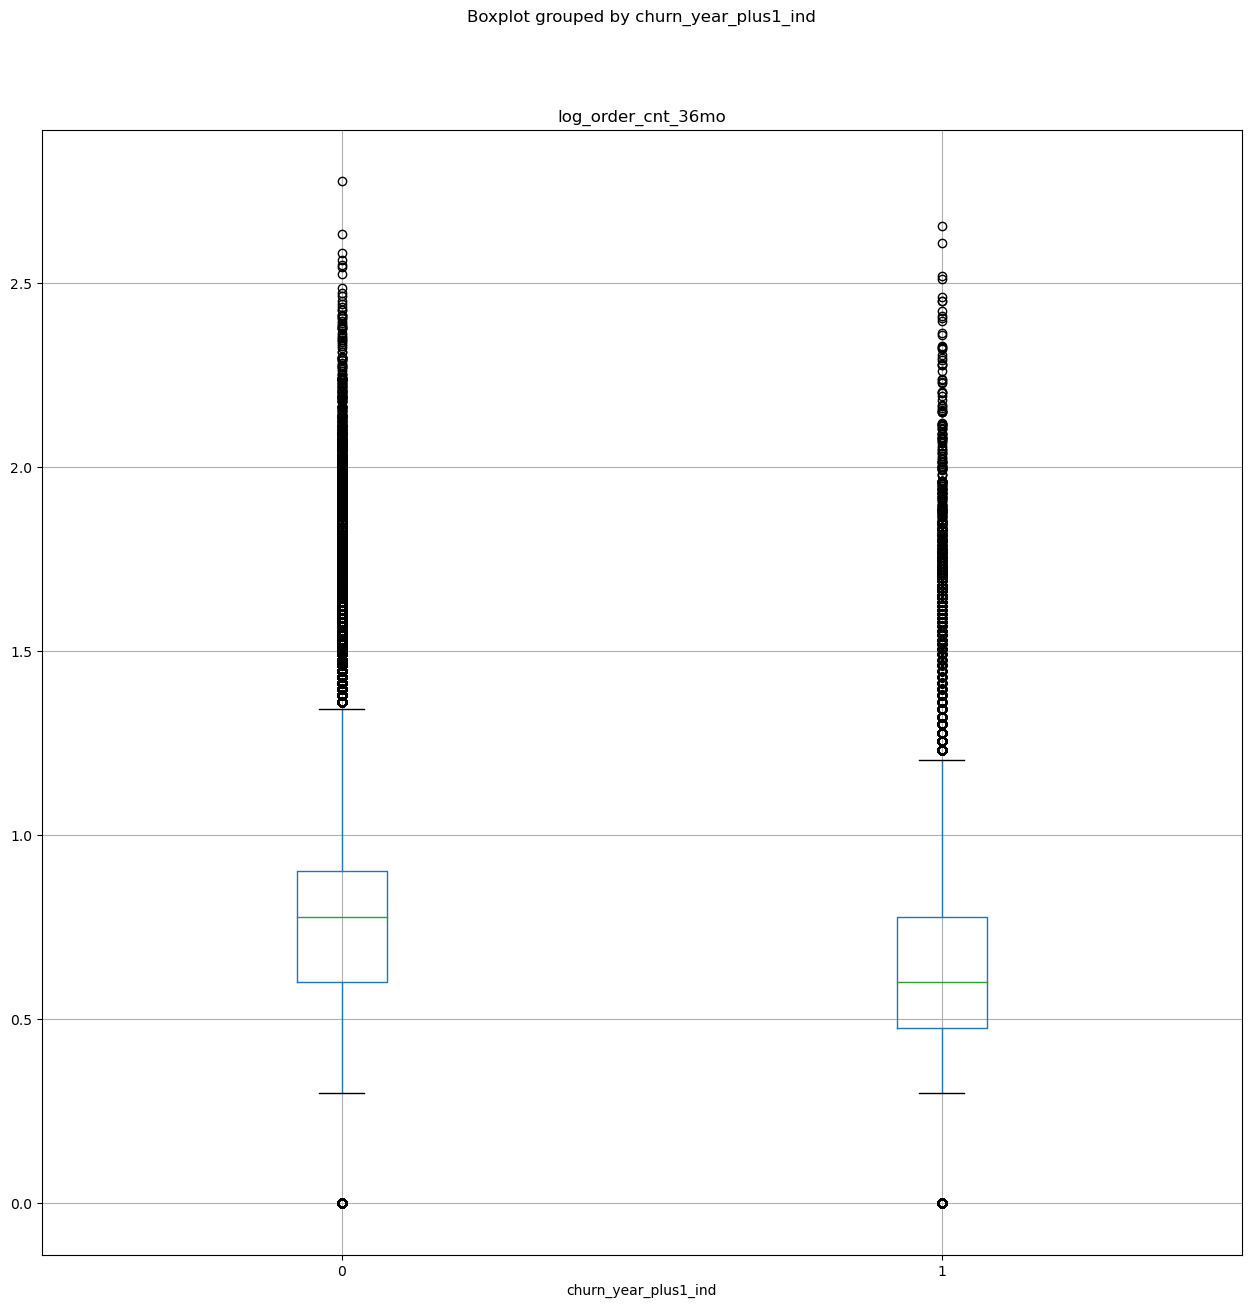

In [5]:
""" A boxplot to investigate the distribution of numeric variables by the levels of the target """

combined_df.boxplot(column='log_order_cnt_36mo', by='churn_year_plus1_ind',figsize=(15,15))

## Printing variable stats:

In [6]:
print(" summary stats on combined data ") 
print(combined_df.describe(include='all').transpose())

 summary stats on combined data 
                     count unique      top   freq      mean       std  min  \
ST                  239356     61       TX  21540       NaN       NaN  NaN   
Zip                 239356  26096  missing    889       NaN       NaN  NaN   
DMA                 239356    216      803   9679       NaN       NaN  NaN   
Area_Cd             239356    384  missing  13034       NaN       NaN  NaN   
emailable         239356.0    NaN      NaN    NaN  0.515011  0.499776  0.0   
...                    ...    ...      ...    ...       ...       ...  ...   
Region_Other      239356.0    NaN      NaN    NaN  0.006643  0.081233  0.0   
Region_South      239356.0    NaN      NaN    NaN   0.27058   0.44426  0.0   
Region_Southeast  239356.0    NaN      NaN    NaN  0.161082  0.367608  0.0   
Region_Southwest  239356.0    NaN      NaN    NaN  0.037267  0.189415  0.0   
Region_West       239356.0    NaN      NaN    NaN  0.159177  0.365842  0.0   

                  25%  50%  75

## Dropping variables we don't want included in modeling, and creating new version of data for modeling:

In [7]:
""" Any categorical variable for which we did not create dummy indicators        """
"""    and other variables we don't want in the model, or which don't make sense """
"""    to be included in model training, we are dropping here:                   """

""" Note:  we also want to drop acct_ID, but we are going to do that after partioning """
"""        because we need acct_ID for partioned sets to for reference later          """

x_train_df = combined_df.drop(['Zip','DMA','Area_Cd','activation_date','event_date',
                            'ST','tier','tier_prev','demog_ownrent','Region'
                              ],axis=1)

x_train_df.shape

(239356, 127)

In [8]:
# Changing any boolean columns into int datatypes to prevent errors
boolean_columns = list(x_train_df.dtypes[x_train_df.dtypes == 'bool'].index)
x_train_df[boolean_columns] = x_train_df[boolean_columns].astype('int')

## Partitioning data into Training and Test sets, creating X vs Y sets, and
##     creating dataframes with just account IDs to be used to rejoin data later:

In [9]:
x_train_df, x_test_df = train_test_split(x_train_df, test_size = 0.30)

""" will need the acct_IDs to rejoin data later, so pulling out now before dropping from actual model training data """

train_acct_IDs_df = x_train_df[['acct_ID']]
test_acct_IDs_df  = x_test_df[['acct_ID']]

""" the target (or dependent) variable is stored in it's own dataframe """

y_train_df = x_train_df[['churn_year_plus1_ind']]
y_test_df  = x_test_df[['churn_year_plus1_ind']]

""" and we want to drop acct_ID and the target variable from the dataframe of independent variables """
""" PLUS we want to drop the target (future timeframe) variables for margin modeling                """

x_train_df = x_train_df.drop(['acct_ID','churn_year_plus1_ind', 'log_margin_Y_pos_1', 'margin_Y_pos_1'
                             ],axis=1)

x_test_df = x_test_df.drop(['acct_ID','churn_year_plus1_ind', 'log_margin_Y_pos_1', 'margin_Y_pos_1'
                             ],axis=1)

x_train_df.shape

(167549, 123)

## Starting with a scikit_learn Logistic Regression Model
##    and using that modeling algorithm to select variables.

## Note:  change the C parameter and rerun to get reasonable number of selected vars.

In [10]:
""" models penalized with the L1 norm have sparse solutions: many of their estimated coefficients are zero """
""" SelectFromModel can be used to to select effects with non-zero coefficients """
""" the parameter C controls the sparsity: the smaller C the fewer features selected """

""" using the ravel simply to avoid warning in log """
y_train_array=np.ravel(y_train_df)

""" start with C = 1.0, then try 0.1, etc """
model1 = linear_model.LogisticRegression(C=0.01, solver='liblinear', penalty='l1', tol=0.01)
model1_fit = model1.fit(x_train_df, y_train_array)
model1_selects = SelectFromModel(model1_fit, prefit=True)
"""x_train_selected_df = model1_selects.transform(x_train_df)"""

""" in lieu of commented-out transform method above, can use this method to explicitly define columns to keep """
x_train_selected_df = x_train_df[x_train_df.columns[model1_selects.get_support()]]
x_test_selected_df  = x_test_df[x_test_df.columns[model1_selects.get_support()]]

coefficients = pd.DataFrame(model1_fit.coef_)
coefficients = np.transpose(coefficients[coefficients.columns[model1_selects.get_support()]])
coefficients = coefficients.reset_index(drop=True)

coefficients_match = pd.concat([pd.DataFrame(x_train_selected_df.columns),coefficients], axis = 1)

coefficients.shape 

(38, 1)

In [11]:
print(" ") 
print("Coefficients for selected variables")
coefficients_match.head(40)

 
Coefficients for selected variables


,0,0
0,emailable,-0.157151
1,solicit_email_ind,-0.158667
2,scheduled_purchase_flg,-4.101423
3,months_since_last_trans,0.407808
4,months_since_first_trans,-0.002851
5,purch_avg_interval,0.000167
6,mail_cnt_36mo,-0.008380
7,call_in_mo_36mo,0.000390
8,call_out_mo_36mo,-0.014622
9,log_order_cnt_36mo,-0.774952


## Need to introduce variable reduction that addresses multicolinearity:

In [12]:
# function to calculate VIF for all independent variables and drop variables with VIF > 10

def calculate_vif_(X, thresh=10):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]
        maxloc = vif.index(max(vif))
    # Drop variables with VIF values greater than 10    
    if max(vif) > thresh: 
        print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
        variables = np.delete(variables, maxloc)
        dropped=True
        
        print('Remaining variables:')
        print(X.columns[variables])
    return X.iloc[:, variables]

x_train_selected_df=calculate_vif_(x_train_selected_df, 10.0)
        
x_train_selected_df.shape

dropping 'log_margin_3yr_avg' at index: 25
Remaining variables:
Index(['emailable', 'solicit_email_ind', 'scheduled_purchase_flg',
       'months_since_last_trans', 'months_since_first_trans',
       'purch_avg_interval', 'mail_cnt_36mo', 'call_in_mo_36mo',
       'call_out_mo_36mo', 'log_order_cnt_36mo', 'log_purch_amt_36mo',
       'log_purch_amt_life', 'log_purch_avg_36mo', 'log_purch_cnt_life',
       'log_purch_cnt_tt_36mo', 'log_resp_cnt_36mo', 'perc_purch_cc_36mo',
       'perc_purch_ck_36mo', 'perc_purch_et_36mo', 'margin_Y_neg_1',
       'margin_Y_neg_2', 'margin_3yr_avg', 'log_margin_Y_neg_1',
       'log_margin_Y_neg_2', 'log_margin_Y_neg_3', 'demog_generations',
       'demog_adults', 'LOR', 'Age', 'tier_2-Silver', 'tier_3-Gold',
       'tier_prev_1-Bronze', 'tier_prev_xxx',
       'demog_ownrent_Definite Owner (any type dwelling unit)',
       'Region_Northeast', 'Region_South', 'Region_West'],
      dtype='object')


(167549, 37)

In [13]:
# function to calculate VIF for all independent variables and drop variables with VIF > 10
thresh=10

X = x_train_selected_df

dropped=True

while dropped==True:
    cols = X.columns
    variables = np.arange(X.shape[1])
    
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]
        maxloc = vif.index(max(vif))

    # Drop variables with VIF values greater than 10    
    if max(vif) > thresh: 
        print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
        variables = np.delete(variables, maxloc)
        dropped=True
        
        print('Remaining Shape:')
        print(X.shape)
    else:
        dropped=False
    X = X.iloc[:, variables]

x_train_selected_df = X

dropping 'log_margin_Y_neg_2' at index: 23
Remaining Shape:
(167549, 37)
dropping 'log_margin_Y_neg_1' at index: 22
Remaining Shape:
(167549, 36)
dropping 'log_purch_amt_36mo' at index: 10
Remaining Shape:
(167549, 35)
dropping 'log_margin_Y_neg_3' at index: 21
Remaining Shape:
(167549, 34)
dropping 'log_purch_amt_life' at index: 10
Remaining Shape:
(167549, 33)
dropping 'log_purch_cnt_tt_36mo' at index: 12
Remaining Shape:
(167549, 32)
dropping 'perc_purch_ck_36mo' at index: 14
Remaining Shape:
(167549, 31)
dropping 'log_purch_cnt_life' at index: 11
Remaining Shape:
(167549, 30)
dropping 'log_purch_avg_36mo' at index: 10
Remaining Shape:
(167549, 29)
dropping 'solicit_email_ind' at index: 1
Remaining Shape:
(167549, 28)
dropping 'Age' at index: 18
Remaining Shape:
(167549, 27)
dropping 'margin_3yr_avg' at index: 14
Remaining Shape:
(167549, 26)
dropping 'log_order_cnt_36mo' at index: 8
Remaining Shape:
(167549, 25)


## Run the step above, repeatedly, until no more variables are dropped.

In [14]:
""" reducing the test set to have the same columns as the training set """

x_test_selected_df=x_test_selected_df[x_train_selected_df.columns]
print('Remaining variables in test set:')
print(x_test_selected_df.columns)
        
x_test_selected_df.shape

Remaining variables in test set:
Index(['emailable', 'scheduled_purchase_flg', 'months_since_last_trans',
       'months_since_first_trans', 'purch_avg_interval', 'mail_cnt_36mo',
       'call_in_mo_36mo', 'call_out_mo_36mo', 'log_resp_cnt_36mo',
       'perc_purch_cc_36mo', 'perc_purch_et_36mo', 'margin_Y_neg_1',
       'margin_Y_neg_2', 'demog_generations', 'demog_adults', 'LOR',
       'tier_2-Silver', 'tier_3-Gold', 'tier_prev_1-Bronze', 'tier_prev_xxx',
       'demog_ownrent_Definite Owner (any type dwelling unit)',
       'Region_Northeast', 'Region_South', 'Region_West'],
      dtype='object')


(71807, 24)

## Using the statsmodels package to see "friendlier" looking Logistic output:

In [15]:
""" for the statsmodels, need to add a constant to fit intercept """

x_train_selected_df = sm.add_constant(x_train_selected_df, has_constant='add')
x_test_selected_df  = sm.add_constant(x_test_selected_df, has_constant='add')

""" modeling with selected variables from steps above """

model = sm.Logit(y_train_df, x_train_selected_df)
result = model.fit(maxiter=100)

print(" ") 
print("Logistic model with selected variables")
print(" ") 
print(result.summary2())
print('AIC: ', result.aic)
print('BIC: ', result.bic)

Optimization terminated successfully.
         Current function value: 0.317796
         Iterations 9
 
Logistic model with selected variables
 
                                            Results: Logit
Model:                          Logit                          Method:                     MLE        
Dependent Variable:             churn_year_plus1_ind           Pseudo R-squared:           0.449      
Date:                           2024-02-06 15:05               AIC:                        106542.6731
No. Observations:               167549                         BIC:                        106793.3989
Df Model:                       24                             Log-Likelihood:             -53246.    
Df Residuals:                   167524                         LL-Null:                    -96634.    
Converged:                      1.0000                         LLR p-value:                0.0000     
No. Iterations:                 9.0000                         Scale:      

## Using the statsmodels Logit model to score the data and evaluate goodness-of-fit:

AROC train:  0.9192159899171831
AROC test:  0.9184028575683424
 
MSE train: 0.09996336451503468
MSE test: 0.10062270533311159
 
testing that the joining process works. if so, these MSE should match the ones above.
mean squared error train: 0.09996336451503468
mean squared error testn: 0.10062270533311159


<Axes: title={'center': 'P_churn_year_plus1_ind'}, xlabel='churn_year_plus1_ind'>

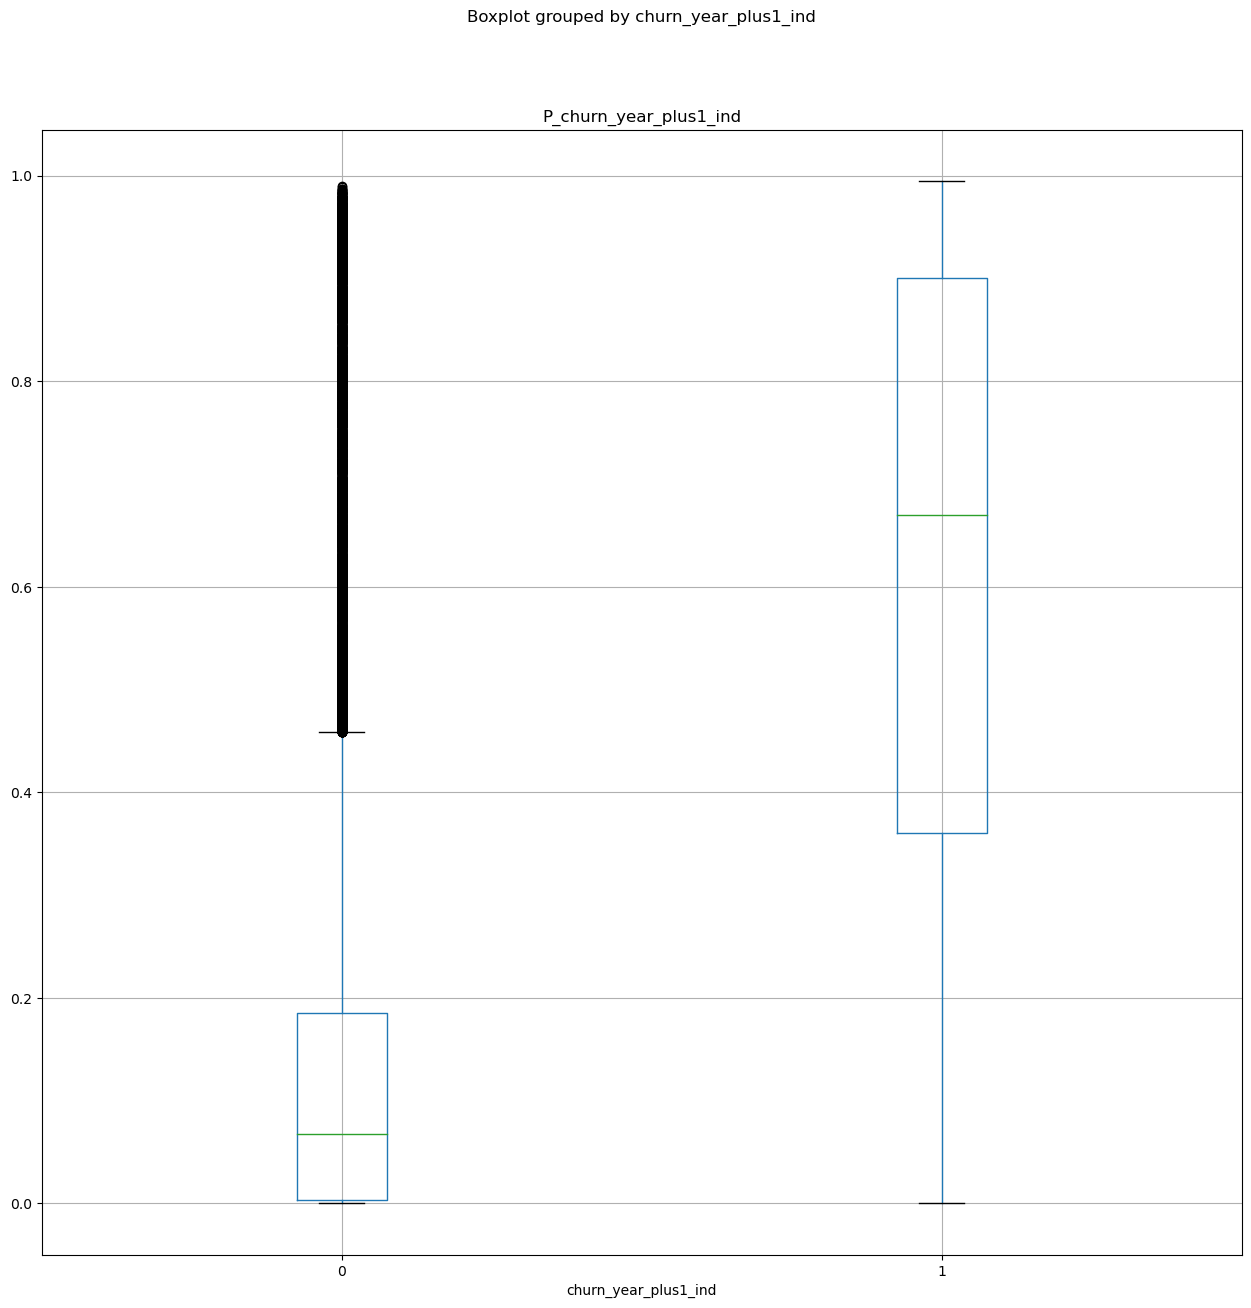

In [16]:
""" predicted values using the model """
""" using numpy copy to store result as an array """
""" manually adding a column header """
predict_train = pd.DataFrame(np.copy(result.predict(x_train_selected_df)), columns=["P_churn_year_plus1_ind"])
predict_test = pd.DataFrame(np.copy(result.predict(x_test_selected_df)), columns=["P_churn_year_plus1_ind"])

print ('AROC train: ', metrics.roc_auc_score(y_train_df, predict_train))
print ('AROC test: ', metrics.roc_auc_score(y_test_df, predict_test))

""" note that the index for the predicted values vector """
""" is reset, and thus complicates a join back with the original """
""" thus, reset the index on the original data, then join with predicted """
""" WARNING: you have to do the same, to join back with dataframe of regressors """
y_train_df = y_train_df.reset_index(drop=True)
y_test_df = y_test_df.reset_index(drop=True)

""" joining predicted and actuals """
""" NOTE:  for reference, for now...to be used more later to create complete """
"""     dataframe with all obs and inputs and outputs """
train_accounts = train_acct_IDs_df.reset_index(drop=True)
pred_v_actual_train = y_train_df.join(predict_train)
pred_v_actual_train = pred_v_actual_train.join(train_accounts)

test_accounts = test_acct_IDs_df.reset_index(drop=True)
pred_v_actual_test = y_test_df.join(predict_test)
pred_v_actual_test = pred_v_actual_test.join(test_accounts)

print(" ") 
print("MSE train:", mean_squared_error(y_train_df, predict_train))
print("MSE test:", mean_squared_error(y_test_df, predict_test))

print(" ") 
print("testing that the joining process works. if so, these MSE should match the ones above.")
print("mean squared error train:" , (np.mean((pred_v_actual_train['churn_year_plus1_ind']-pred_v_actual_train['P_churn_year_plus1_ind'])**2)))
print("mean squared error testn:" , (np.mean((pred_v_actual_test['churn_year_plus1_ind']-pred_v_actual_test['P_churn_year_plus1_ind'])**2)))

pred_v_actual_test.boxplot(column='P_churn_year_plus1_ind', by='churn_year_plus1_ind',figsize=(15,15))

## Now to try a more advanced Machine Learning algorithm to see if we can get a better model:
**NOTE** - This cell might take some time to run depending on number of estimators 

Make function for scoring model

Include optional *fullstats* parameter which determines if full stats and plots are generated

In [17]:
def score_model(my_model, y_test_df, y_train_df, fullstats=True):
    """ returns overall accuracy"""
    accuracy = my_model.score(x_test_selected_df, y_test_df)
    print("GB overall accuracy:", accuracy)

    """ predicted values using the model """
    """ using numpy copy to store result as an array """
    """ manually adding a column header """
    predict_train = pd.DataFrame(np.copy(my_model.predict_proba(x_train_selected_df)[:, 1]), columns=["P_churn_year_plus1_ind"])
    predict_test = pd.DataFrame(np.copy(my_model.predict_proba(x_test_selected_df)[:, 1]), columns=["P_churn_year_plus1_ind"])

    print ('AROC train: ', metrics.roc_auc_score(y_train_df, predict_train))
    print ('AROC test: ', metrics.roc_auc_score(y_test_df, predict_test))

    if fullstats:

        """ note that the index for the predicted values vector """
        """ is reset, and thus complicates a join back with the original """
        """ thus, reset the index on the original data, then join with predicted """
        """ WARNING: you have to do the same, to join back with dataframe of regressors """
        y_train_df = y_train_df.reset_index(drop=True)
        y_test_df = y_test_df.reset_index(drop=True)

        train_accounts = train_acct_IDs_df.reset_index(drop=True)
        pred_v_actual_train = y_train_df.join(predict_train)
        pred_v_actual_train = pred_v_actual_train.join(train_accounts)


        test_accounts = test_acct_IDs_df.reset_index(drop=True)
        pred_v_actual_test = y_test_df.join(predict_test)
        pred_v_actual_test = pred_v_actual_test.join(test_accounts)

        print(" ") 
        print("MSE train:", mean_squared_error(y_train_df, predict_train))
        print("MSE test:", mean_squared_error(y_test_df, predict_test))

        print(" ") 
        print("testing that the joining process works. if so, these MSE should match the ones above.")
        print("mean squared error train:" , (np.mean((pred_v_actual_train['churn_year_plus1_ind']-pred_v_actual_train['P_churn_year_plus1_ind'])**2)))
        print("mean squared error test:" , (np.mean((pred_v_actual_test['churn_year_plus1_ind']-pred_v_actual_test['P_churn_year_plus1_ind'])**2)))


        pred_v_actual_test.boxplot(column='P_churn_year_plus1_ind', by='churn_year_plus1_ind',figsize=(15,15))

        """ plotting AROC with each iteration of the Gradient Boosting algorithm """

        """ converting Y dataframes into arrays as needed for logic below """
        y_traint_array = y_train_df.values
        y_test_array = y_test_df.values

        test_AROC  = np.zeros((params['n_estimators'],), dtype=np.float64)
        train_AROC = np.zeros((params['n_estimators'],), dtype=np.float64)

        for i, y_pred in enumerate(my_model.staged_predict_proba(x_test_selected_df)):
            test_AROC[i] = metrics.roc_auc_score(y_test_array, y_pred[:, 1])

        for i, y_pred in enumerate(my_model.staged_predict_proba(x_train_selected_df)):
            train_AROC[i] = metrics.roc_auc_score(y_train_array, y_pred[:, 1])

        plt.figure(figsize=(15,15))
        plt.subplot(1, 2, 1)
        plt.title('AROC by iteration')
        plt.plot(np.arange(params['n_estimators']) + 1, train_AROC, 'b-',
                label='Training Set AROC')
        plt.plot(np.arange(params['n_estimators']) + 1, test_AROC, 'r-',
                label='Test Set AROC')
        plt.legend(loc='upper right')
        plt.xlabel('Boosting Iterations')
        plt.ylabel('AROC')

Gradient Boosting Model 1 (model2)

In [18]:
""" Gradient Boosting """
params = {'n_estimators': 50, 'min_samples_split': 2,  'max_depth': 5, 'learning_rate': 0.01}
model2 = GradientBoostingClassifier(**params)

""" had to switch the order of X and Y for the fit to work with GradientBoosting """
result2 = model2.fit(x_train_selected_df, y_train_array)

score_model(result2, y_test_df, y_train_df, fullstats=False)

GB overall accuracy: 0.7777236202598632
AROC train:  0.9303373031044391
AROC test:  0.9287347740420426


Gradient Boosting Model 2 (model3)

In [19]:
""" Gradient Boosting """
params = {'n_estimators': 250, 'min_samples_split': 2,  'max_depth': 5, 'learning_rate': 0.01}
model3 = GradientBoostingClassifier(**params)

""" had to switch the order of X and Y for the fit to work with GradientBoosting """
result3 = model3.fit(x_train_selected_df, y_train_array)

score_model(result3, y_test_df, y_train_df, fullstats=False)

GB overall accuracy: 0.8761402091718078
AROC train:  0.9357464233644661
AROC test:  0.9337033279034304


Gradient Boosting Model 3 (model4)

In [20]:
""" Gradient Boosting """
params = {'n_estimators': 50, 'min_samples_split': 2,  'max_depth': 5, 'learning_rate': 0.1}
model4 = GradientBoostingClassifier(**params)

""" had to switch the order of X and Y for the fit to work with GradientBoosting """
result4 = model4.fit(x_train_selected_df, y_train_array)

score_model(result4, y_test_df, y_train_df, fullstats=False)

GB overall accuracy: 0.8779227651900232
AROC train:  0.9388845336339674
AROC test:  0.9360821301789539


### Champion Churn Model
The gradient boosting model with 0.01 learning rate and n_estimators=50 will be chosen as champion because it had best performance while also being fastest in compute time

GB overall accuracy: 0.7777236202598632
AROC train:  0.9303373031044391
AROC test:  0.9287347740420426
 
MSE train: 0.12990865805145305
MSE test: 0.1302641800704696
 
testing that the joining process works. if so, these MSE should match the ones above.
mean squared error train: 0.12990865805145305
mean squared error test: 0.1302641800704696


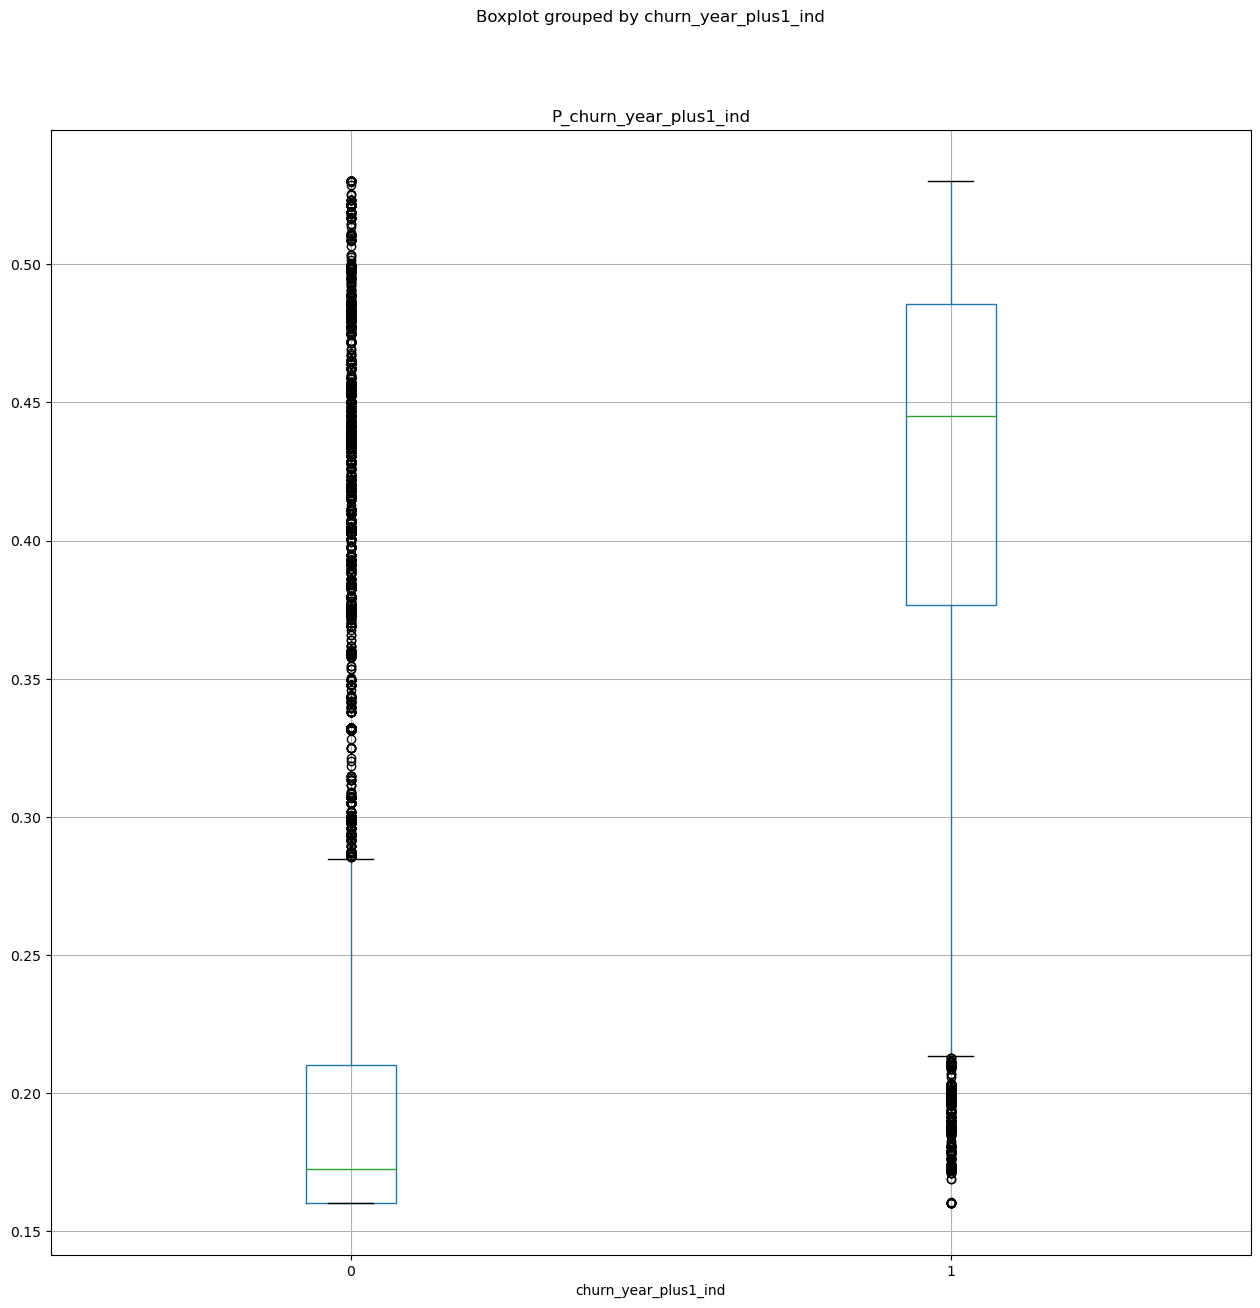

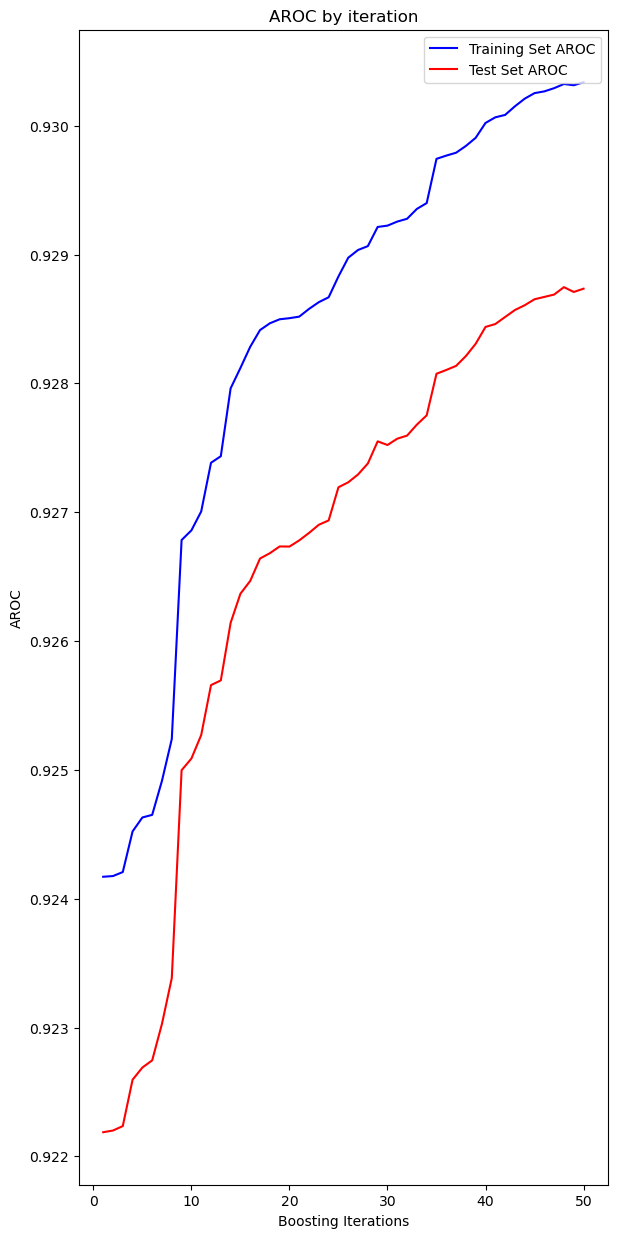

In [21]:
score_model(result2, y_test_df, y_train_df, fullstats=True)

## Feature Importance for the Gradient Boosting Model:

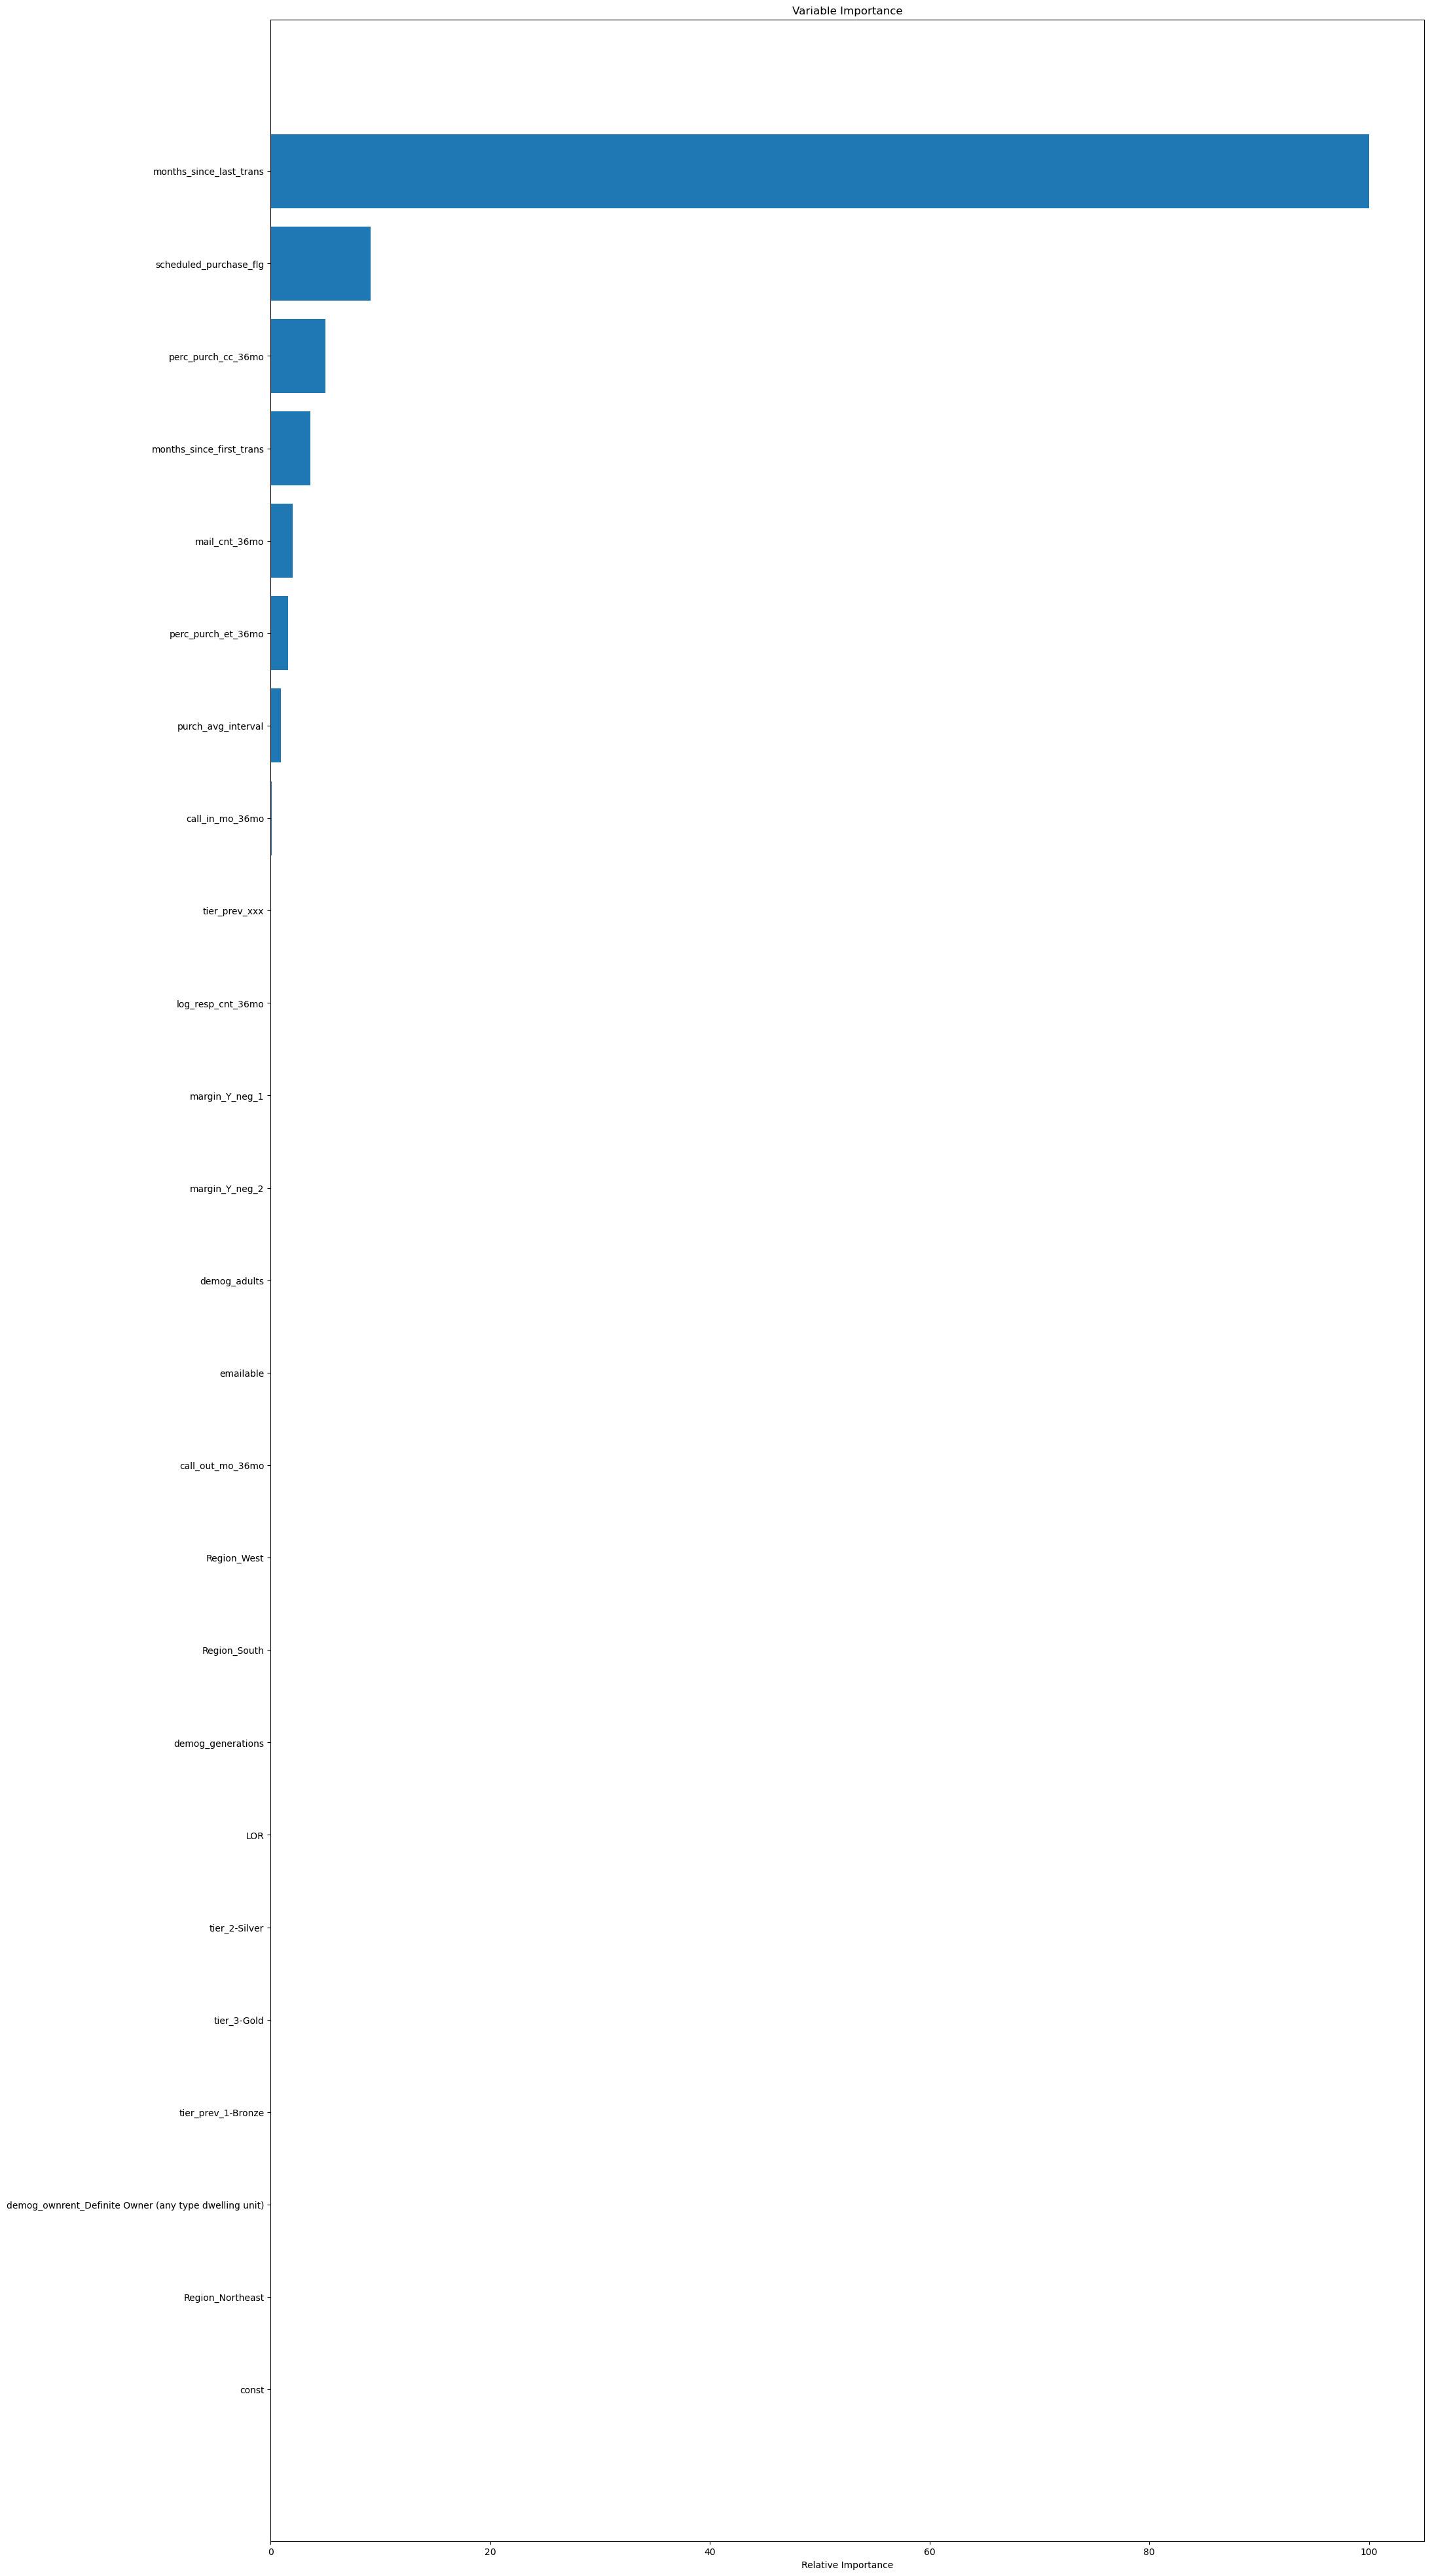

In [22]:
feature_importance = model2.feature_importances_
""" make importances relative to max importance """
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(50,50))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x_train_selected_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### Append the train and test sets, and keeping the acct_IDs and predicted churn probabilities

In [23]:
""" append together train and test predicted values, keeping only acct ID and predicted values """

pred_v_actual_train = pd.concat([pred_v_actual_train, pred_v_actual_test], ignore_index=True)

pred_v_actual_train = pred_v_actual_train.drop(['churn_year_plus1_ind'],axis=1)

""" and then save predicted values by acct ID to csv """
pred_v_actual_train.to_csv('churn_scores.csv',index=False)